# The basic, ontology based ANN configurator with TensorFlow
This is the example of ANN ontology which support TensorFlow

In [1]:
from cognipy.ontology import Ontology,CQL
from cognipy.edit import CnlEditBox, CnlQueryForConcept

We need some functionalites that will allow us to manipulate/print the dataframes

In [2]:
import pandas as pd

Now we are ready to load the core ontology. It just contains the basic ANN concepts. We will define the net a little bit later.

In [3]:
ed2=CnlEditBox('./ann2.encnl')
ed2

<IPython.core.display.Javascript object>

In [5]:
onto=Ontology("cnl/file","./ann2.encnl")

We define now the internat structure of the network with few simple sentences:

In [6]:
netName="Net-1"

In [7]:
onto.insert_cnl(netName+" is a basic-neural-net that has-part L-In. \
L-In is an basic-neural-net-input-layer that connects-to Ann-1-F-1 and has-width equal-to 12288.\
Ann-1-F-1 is a multilayer-neural-net-fragment that connects-to Ann-1-F-2 and has-shape equal-to '25' and has-activation equal-to 'RELU'.\
Ann-1-F-2 is a multilayer-neural-net-fragment that connects-to L-Out and has-shape equal-to '12' and has-activation equal-to 'RELU'.\
L-Out is an basic-neural-net-output-layer that has-number-of-classes equal-to 6.\
")

Lets setup the initializer and optimiser for our ANN.

In [8]:
onto.insert_cnl(netName+" has-part Initializer-1. Initializer-1 is an initializer that has-character equal-to 'Xavier'.")

In [9]:
onto.insert_cnl(netName+" has-part Optimizer-1. Optimizer-1 is an optimizer that has-character equal-to 'ADAM'.")

In [10]:
parts = onto.instances_of("a thing")
parts

['Optimizer-1',
 'Initializer-1',
 'L-Out',
 'Ann-1-F-2',
 'Ann-1-F-1',
 'L-In',
 'Net-1']

In [11]:
inp   = onto.select_instances_of("a neural-net-input-layer that is-part-of "+netName)
outp  = onto.select_instances_of("a neural-net-output-layer that is-part-of "+netName)
frags = onto.select_instances_of("a neural-net-fragment that is-part-of "+netName)
init  = onto.select_instances_of("a initializer that is-part-of "+netName)
opti  = onto.select_instances_of("a optimizer that is-part-of "+netName)

In [12]:
x_n=inp['has-width'][0]
y_n=outp['has-number-of-classes'][0]
print(x_n)
print(y_n)

12288
6


In [13]:
frags=frags.sort_values('has-index')
frags

,Instance,connects-to,is-part-of,has-activation,has-shape,has-index
1,Ann-1-F-1,Ann-1-F-2,Net-1,RELU,25,1
0,Ann-1-F-2,L-Out,Net-1,RELU,12,2


In [14]:
shape=[int(x) for x in str.split(frags['has-shape'].values[1],":")]
shape

[12]

In [15]:
activations = frags['has-activation'].values[1]
activations

'RELU'

In [16]:
init

,Instance,is-part-of,has-character
0,Initializer-1,Net-1,Xavier


In [17]:
opti

,Instance,is-part-of,has-character
0,Optimizer-1,Net-1,ADAM


# TEST

In [29]:
!pip install tensorflow

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

import pandas as pd

ModuleNotFoundError: No module named 'tensorflow'

In [18]:
inp   = onto.select_instances_of("a neural-net-input-layer that is-part-of "+netName)
outp  = onto.select_instances_of("a neural-net-output-layer that is-part-of "+netName)
frags = onto.select_instances_of("a neural-net-fragment that is-part-of "+netName).sort_values('has-index')
init  = onto.select_instances_of("a initializer that is-part-of "+netName)
opti  = onto.select_instances_of("a optimizer that is-part-of "+netName)
n_x=inp['has-width'][0]
n_y=outp['has-number-of-classes'][0]

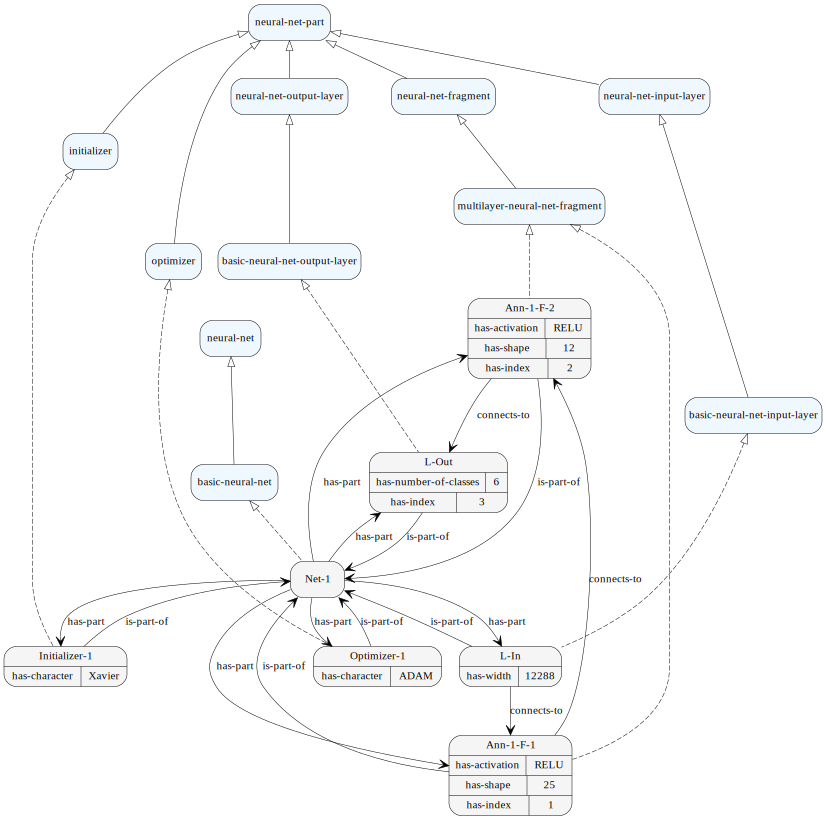

In [19]:
onto.draw_graph()

In [20]:
def create_placeholders():
    X = tf.placeholder(tf.float32,shape=(n_x,None))
    Y = tf.placeholder(tf.float32,shape=(n_y,None))
    return X, Y

In [21]:
X, Y = create_placeholders()
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


In [22]:
def get_initializer(character):
    if character=="Xavier":
        return tf.contrib.layers.xavier_initializer
    elif character=="Zero":
        return tf.zeros_initializer
    raise NotImplementedError

In [23]:
def get_activation(activation):
    if activation=="RELU":
        return tf.nn.relu
    elif activation=="Sigmoid":
        return tf.nn.sigmoid
    elif activation=="Tanh":
        return tf.nn.tanh
    raise NotImplementedError

In [24]:
def get_optimizer(optimizer):
    if optimizer=="ADAM":
        return tf.train.AdamOptimizer
    elif optimizer=="GradientDescent":
        return tf.train.GradientDescentOptimizer
    raise NotImplementedError

In [25]:
def initialize_parameters():
    parameters=[]
    activations=[]

    W_init = get_initializer(init['has-character'][0])
    b_init = tf.zeros_initializer
    w=n_x
    nfragrows=frags.shape[0]

    idx=1
    for i in range(0,nfragrows):
        shape=[int(x) for x in str.split(frags['has-shape'].values[i],":")]
        activation = get_activation(frags['has-activation'].values[i])

        for lw in shape:
            W1 = tf.get_variable("W"+str(idx), [lw,w], initializer = W_init(seed = 1))
            b1 = tf.get_variable("b"+str(idx), [lw,1], initializer = b_init())
            parameters.append({"W":W1,"b":b1})
            activations.append(activation)
            idx=idx+1
            w=lw

    lw=n_y
    W1 = tf.get_variable("W"+str(idx), [lw,w], initializer = W_init(seed = 1))
    b1 = tf.get_variable("b"+str(idx), [lw,1], initializer = b_init())
    parameters.append({"W":W1,"b":b1})
    activations.append(None)

    return parameters, activations    

In [26]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters, activations = initialize_parameters()
    for layer in zip(parameters,activations):
        print("W = " + str(layer[0]["W"]))
        print("b = " + str(layer[0]["b"]))
        print("f = " + str(layer[1]))
        

W = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
f = <function relu at 0x000001C1844C9A60>
W = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
f = <function relu at 0x000001C1844C9A60>
W = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>
f = None


In [27]:
def forward_propagation(X,parameters,activations):        
    A1 = X
    Z1 = None
    for layer in zip(parameters,activations):
        W1 = layer[0]['W']
        b1 = layer[0]['b']
        activation = layer[1]
        Z1=tf.add(tf.matmul(W1,A1),b1)
        if activation!=None :
            A1=activation(Z1)

    return Z1

In [28]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders()
    parameters,activations = initialize_parameters()
    Z3 = forward_propagation(X, parameters,activations)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [29]:
def compute_cost(Z1, Y):
    """
    Computes the cost

    Arguments:
    Z1 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost    

In [30]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders()
    parameters,activations = initialize_parameters()
    Z1 = forward_propagation(X, parameters,activations)
    cost = compute_cost(Z1, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [31]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
      num_epochs = 1500, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost

    X, Y = create_placeholders()

    parameters,activations = initialize_parameters()
    Z1 = forward_propagation(X,parameters,activations)
    cost = compute_cost(Z1,Y)

    optimizer =  get_optimizer(opti['has-character'][0])(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z1), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters,activations

In [32]:
import h5py
def load_dataset():
    train_dataset = h5py.File('./datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [33]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


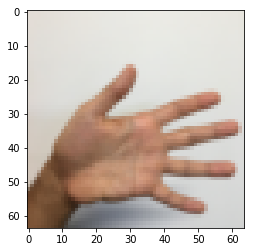

In [34]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [35]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [36]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [37]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572939
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381015
Cost after epoch 600: 0.313829
Cost after epoch 700: 0.254169
Cost after epoch 800: 0.203800
Cost after epoch 900: 0.166474
Cost after epoch 1000: 0.141408
Cost after epoch 1100: 0.107606
Cost after epoch 1200: 0.086730
Cost after epoch 1300: 0.061016
Cost after epoch 1400: 0.050911


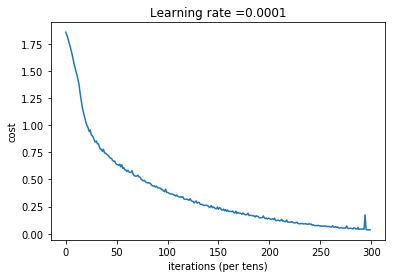

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [38]:
parameters,activations = model(X_train, Y_train, X_test, Y_test)

In [39]:
def prepare_parameters_for_prediction(parameters):        
    params=[]
    for layer in parameters:
        W1 = tf.convert_to_tensor(layer['W'])
        b1 = tf.convert_to_tensor(layer['b'])
        params.append({"W":W1,"b":b1})
    return params

In [40]:
params=prepare_parameters_for_prediction(parameters)
params

[{'W': <tf.Tensor 'Const_2:0' shape=(25, 12288) dtype=float32>,
  'b': <tf.Tensor 'Const_3:0' shape=(25, 1) dtype=float32>},
 {'W': <tf.Tensor 'Const_4:0' shape=(12, 25) dtype=float32>,
  'b': <tf.Tensor 'Const_5:0' shape=(12, 1) dtype=float32>},
 {'W': <tf.Tensor 'Const_6:0' shape=(6, 12) dtype=float32>,
  'b': <tf.Tensor 'Const_7:0' shape=(6, 1) dtype=float32>}]

In [41]:
def predict(X, params,activations):
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation(x, params, activations)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

C:\Users\pkapl\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pkapl\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':


Your algorithm predicts: y = 3


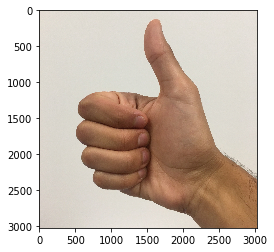

In [42]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "./images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, params,activations)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))